In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# A - Importação e limpeza
df = pd.read_csv("a_teste.csv")  # Corrigido: pd.read_csv()

# Verificando dados
print(df.info())
print(df.head())

# Garantindo tipos corretos
df["renda_media"] = df["renda_media"].astype(float)
df["idade_media"] = df["idade_media"].astype(int)
df["preco_medio_hubs"] = df["preco_medio_hubs"].astype(float)

# B - NumPy: regra de negócio (classificação)

condicoes_etaria = [
    df["idade_media"] < 30,
    (df["idade_media"] >= 30) & (df["idade_media"] < 45),
    df["idade_media"] >= 45
]
etarias = ["jovem", "adulto", "sênior"]

df["faixa_etaria_predominante"] = np.select(condicoes_etaria, etarias, default="indefinido")

condicoes_renda = [
    df["renda_media"] < 3500,
    (df["renda_media"] >= 3500) & (df["renda_media"] < 4000),
    df["renda_media"] >= 4000
]
rendaclass = ["baixa", "média", "alta"]

df["faixa_renda"] = np.select(condicoes_renda, rendaclass, default="indefinido")

# C - Pontuação (regra de negócio)
df["pontuacao"] = (
    np.where(df["faixa_etaria_predominante"] == "jovem", 1, 0.8) * 0.4 +
    np.where(df["faixa_renda"] == "alta", 1,
             np.where(df["faixa_renda"] == "média", 0.7, 0.4)) * 0.4 +
    (df["preco_medio_hubs"] / df["preco_medio_hubs"].max()) * 0.2
)

# Ordenar pelo maior valor de pontuação
df = df.sort_values(by="pontuacao", ascending=False)

# Exibir resultado final
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   municipio         7 non-null      object
 1   renda_media       7 non-null      int64 
 2   idade_media       7 non-null      int64 
 3   preco_medio_hubs  7 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 356.0+ bytes
None
        municipio  renda_media  idade_media  preco_medio_hubs
0       São Paulo         4200           32                75
1  Rio de Janeiro         3900           35                68
2        Curitiba         3700           34                60
3  Belo Horizonte         3500           33                62
4          Recife         3200           30                50
        municipio  renda_media  idade_media  preco_medio_hubs  \
0       São Paulo       4200.0           32              75.0   
6    Porto Alegre       4000.0           38              70.0 

In [3]:
print(df.columns)
print(df.dtypes)
df.head()

Index(['municipio', 'renda_media', 'idade_media', 'preco_medio_hubs',
       'faixa_etaria_predominante', 'faixa_renda', 'pontuacao'],
      dtype='object')
municipio                     object
renda_media                  float64
idade_media                    int64
preco_medio_hubs             float64
faixa_etaria_predominante     object
faixa_renda                   object
pontuacao                    float64
dtype: object


,municipio,renda_media,idade_media,preco_medio_hubs,faixa_etaria_predominante,faixa_renda,pontuacao
0,São Paulo,4200.0,32,75.0,adulto,alta,0.920000
6,Porto Alegre,4000.0,38,70.0,adulto,alta,0.906667
1,Rio de Janeiro,3900.0,35,68.0,adulto,média,0.781333
3,Belo Horizonte,3500.0,33,62.0,adulto,média,0.765333
2,Curitiba,3700.0,34,60.0,adulto,média,0.760000


In [4]:
# Tabela resumo
tabela_resumo = df.groupby(["faixa_etaria_predominante", "faixa_renda"])["preco_medio_hubs"].agg(["mean", "median", "max"]).reset_index()
tabela_resumo.columns = ["Faixa Etária", "Faixa Renda", "Média Preço", "Mediana", "Máximo"]
tabela_resumo

,Faixa Etária,Faixa Renda,Média Preço,Mediana,Máximo
0,adulto,alta,72.500000,72.5,75.0
1,adulto,baixa,50.000000,50.0,50.0
2,adulto,média,63.333333,62.0,68.0
3,jovem,baixa,45.000000,45.0,45.0


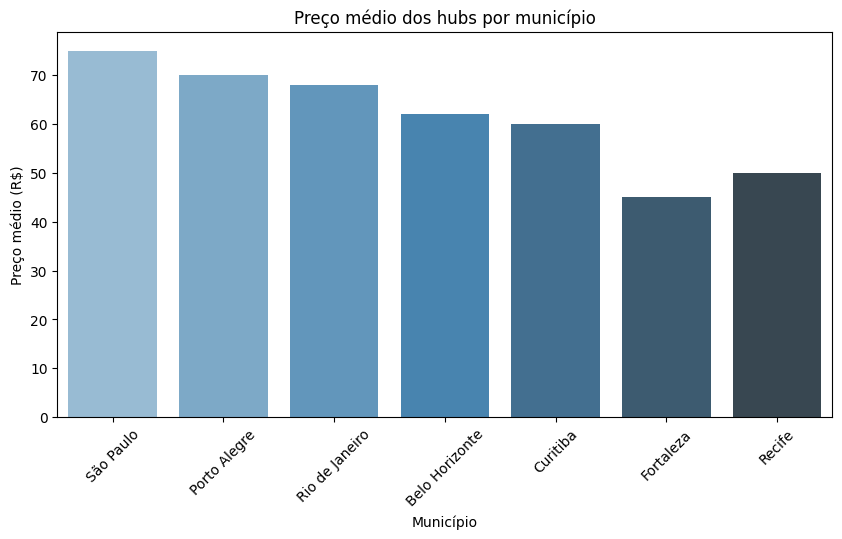

In [5]:
# visualização com Seaborn
plt.figure(figsize=(10,5))
sns.barplot(x="municipio", y="preco_medio_hubs", hue="municipio",
            data=df, palette="Blues_d", dodge=False, legend=False)
plt.title("Preço médio dos hubs por município")
plt.xlabel("Município")
plt.ylabel("Preço médio (R$)")
plt.xticks(rotation=45)
plt.show()

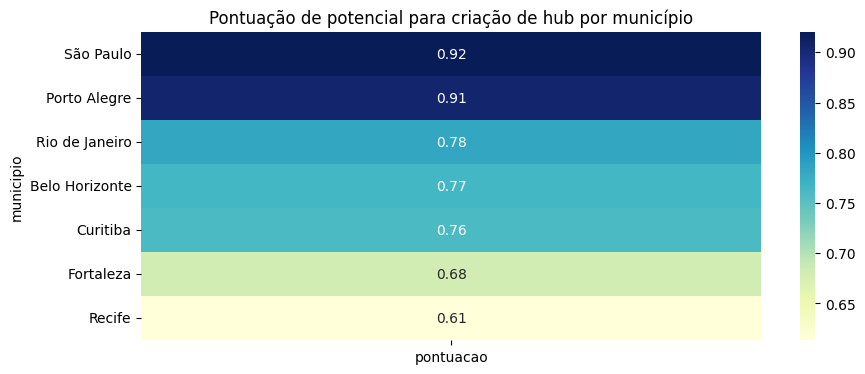

In [6]:
# D - Visualização com Seaborn
plt.figure(figsize=(10,4))
sns.heatmap(df.set_index("municipio")[["pontuacao"]], annot=True, cmap="YlGnBu")
plt.title("Pontuação de potencial para criação de hub por município")
plt.show()

In [7]:
# Adicionando coordenadas aproximadas das principais cidades brasileiras
coordenadas = {
    "São Paulo": (-23.5505, -46.6333),
    "Rio de Janeiro": (-22.9068, -43.1729),
    "Curitiba": (-25.4284, -49.2733),
    "Belo Horizonte": (-19.9167, -43.9345),
    "Recife": (-8.0476, -34.8770),
    "Fortaleza": (-3.7319, -38.5267),
    "Porto Alegre": (-30.0346, -51.2177)
}

df["Latitude"] = df["municipio"].map(lambda x: coordenadas[x][0])
df["Longitude"] = df["municipio"].map(lambda x: coordenadas[x][1])

In [8]:
# Classificação final com base na pontuação
df["Categoria"] = np.select(
    [
        df["pontuacao"] >= 0.85,
        (df["pontuacao"] >= 0.7) & (df["pontuacao"] < 0.85),
        df["pontuacao"] < 0.7
    ],
    ["Excelente", "Boa", "Oportunidade"],
    default="Indefinido"
)

# Conferir o resultado
df[["municipio", "pontuacao", "Categoria"]]

,municipio,pontuacao,Categoria
0,São Paulo,0.920000,Excelente
6,Porto Alegre,0.906667,Excelente
1,Rio de Janeiro,0.781333,Boa
3,Belo Horizonte,0.765333,Boa
2,Curitiba,0.760000,Boa
5,Fortaleza,0.680000,Oportunidade
4,Recife,0.613333,Oportunidade


In [9]:
# =======================
# C - Visualização com Plotly
fig = px.scatter_mapbox(
    df, 
    lat="Latitude", 
    lon="Longitude", 
    color="Categoria",
    size="pontuacao",        # tamanho da bolinha = pontuação
    hover_name="municipio",
    hover_data={
        "renda_media": True,
        "preco_medio_hubs": True,
        "pontuacao": True
    },
    zoom=4,
    height=600,
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(title="Melhores lugares para criação de Hubs no Brasil")
fig.show()

C:\Users\henrique.mourao\AppData\Local\Temp\ipykernel_8820\3447752934.py:3: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(
